# Проект: вариант 3:


Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### Справка о данных:
1. users_*.csv – информация о пользователях:

    - uid – идентификатор пользователя
    - age – возраст
    - attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры * 1000)
    - coins – число монеток (внутренняя валюта)
    - country – страна
    - visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
    - gender – пол
    - age_filter_start  – фильтр поиска, мин. значение
    - age_filter_end  – фильтр поиска, макс. значение
    - views_count – число полученных оценок
    - was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
    - is_premium –  является ли премиум
    - total_revenue – нормированная выручка


2. transactions_*.csv – информация о платежах пользователей:

    - uid – идентификатор пользователя
    - country – страна
    - joined_at – дата и время регистрации
    - paid_at – дата и время покупки
    - revenue – нормированная выручка
    - payment_id – идентификатор платежа
    - from_page – откуда пользователь перешел на страницу оплаты
    - product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, norm, shapiro, levene
import pingouin as pg
from tqdm.auto import tqdm

Все что буду использовать, вставлю в самое начало кода:

In [99]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.mean,  # интересующая нас статистика
        bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

### Преподготовка данных:

In [100]:
user_test = pd.read_csv("user_test.csv", sep=';')
users_control1 = pd.read_csv("users_control1.csv", sep=';')
users_control2 = pd.read_csv("users_control2.csv", sep=';')
transaction_test = pd.read_csv("transaction_test.csv", sep=';')
transaction_control1 = pd.read_csv("transaction_control1.csv", sep=';')
transaction_control2 = pd.read_csv("transaction_control2.csv", sep=';')

In [101]:
display(user_test.head(), transaction_test.head())

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [102]:
transaction_control1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [103]:
transaction_control1 = transaction_control1.dropna()

In [104]:
user_test['coins'] = user_test['coins'].fillna(0)
users_control1['coins'] = users_control1['coins'].fillna(0)
users_control2['coins'] = users_control2['coins'].fillna(0)

In [105]:
user_test['was_premium'] = user_test['was_premium'].fillna(0)
users_control1['was_premium'] = users_control1['was_premium'].fillna(0)
users_control2['was_premium'] = users_control2['was_premium'].fillna(0)

user_test['is_premium'] = user_test['is_premium'].fillna(0)
users_control1['is_premium'] = users_control1['is_premium'].fillna(0)
users_control2['is_premium'] = users_control2['is_premium'].fillna(0)

##### Был ли эксперимент успешен в целом:
____
Сначала посмотрю на выбросы и удалю их в случае выявления:

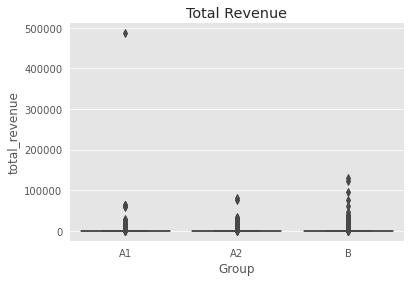

In [106]:
users_A1 = users_control1.assign(Group="A1")
users_A2 = users_control2.assign(Group="A2")
users_B = user_test.assign(Group="B")

# New dataframe Groups 3in1
u = pd.concat([users_A1, users_A2, users_B])

sns.boxplot(x="Group", y="total_revenue", data=u).set_title('Total Revenue')
sns.despine()

In [107]:
u.shape[0]

12912

В группах A1 и A2 есть выбросы и от них лучше всего избавиться.

In [108]:
users_A1.query("total_revenue > 200000")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,A1


In [109]:
u = u.query('uid != 892333905')
transaction_control1 = transaction_control1.query('uid != 892333905')
users_control1 = users_control1.query('uid != 892333905')

In [110]:
u.shape[0]

12911

In [113]:
ctr1 = users_control1.query("total_revenue > 0")
ctr2 = users_control2.query("total_revenue > 0")
test1 = user_test.query("total_revenue > 0")

А теперь можно посмотреть удачно ли у нас был проведен A/A тест и для этого H0 = A1 == A2, а H1 что A1 != A2, но когда я пытаюсь объяснить что это такое, то просто показываю данный мем:

<img src="https://raw.githubusercontent.com/CloudChaoszero/Presentations/d641be8e1d90dda482f9cc2a955990b1497277b2/PyBayTalks/2019/AB-Testing-Python/Resources/Images/a_a_test_meme.png">

  0%|          | 0/1000 [00:00<?, ?it/s]

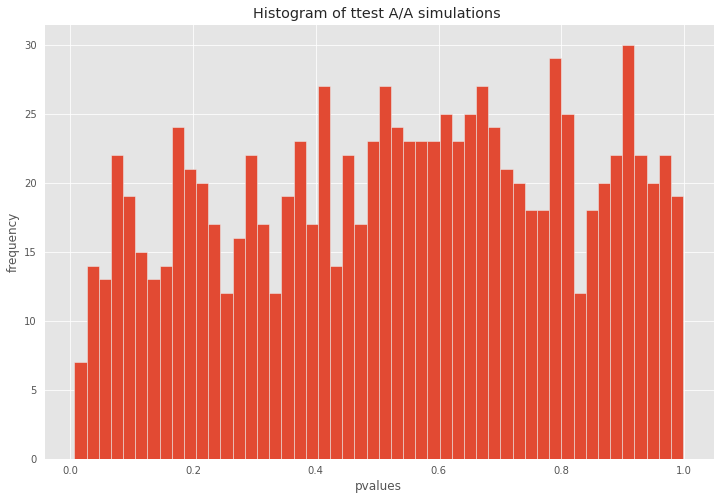

0.022

In [114]:
n = 100000
simulations = 1000
n_s = 1000
res = []
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = users_control1.total_revenue.sample(n_s, replace=False).values
    s2 = users_control2.total_revenue.sample(n_s, replace=False).values
    res.append(ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.figure(figsize=(12, 8))
plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

FPR < 0.05, а именно такую границу обычно берут и значит сплитовалка работает корректно;

При этом перед этим я бы хотел немного поэскплорить данные и я начну с построение боксплотов и других графиков
Также спасибо, что направил меня, так как у меня правда была неуверенность в таких задачках, но я понял, что стоит лишь начать экспериментировать и это возможно к чему-то приведет :)

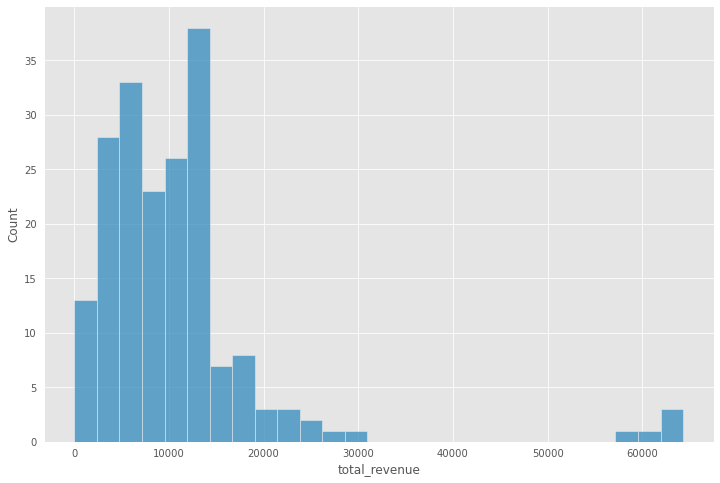

In [115]:
plt.figure(figsize=(12, 8))
sns.histplot(ctr1.total_revenue)
sns.despine()

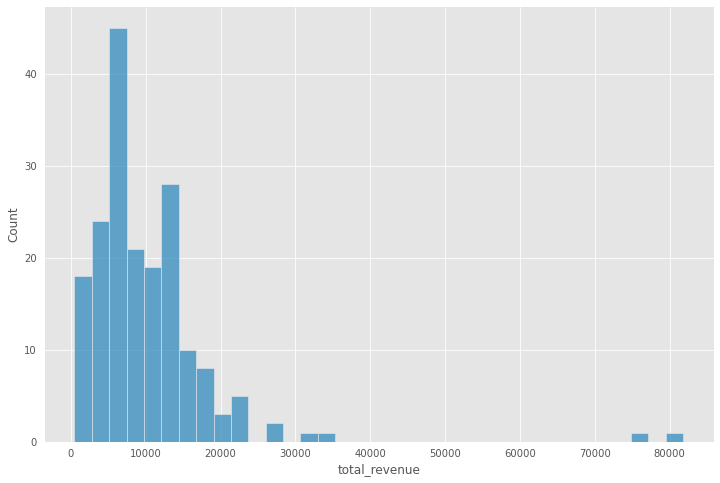

In [116]:
plt.figure(figsize=(12, 8))
sns.histplot(ctr2.total_revenue)
sns.despine()

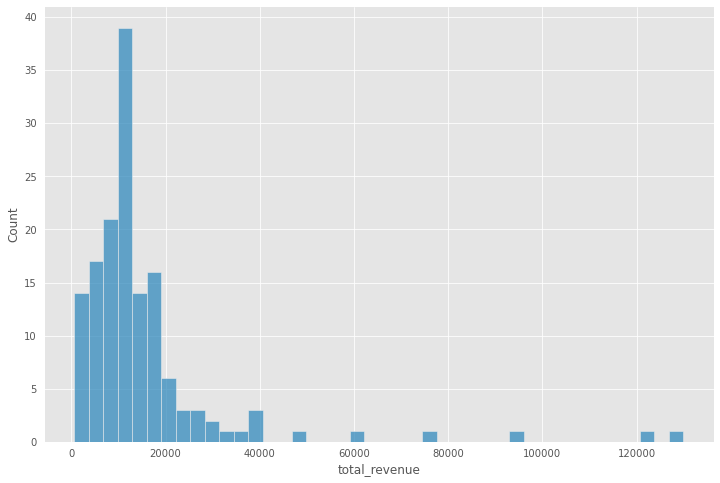

In [117]:
plt.figure(figsize=(12, 8))
sns.histplot(test1.total_revenue)
sns.despine()

Здесь стоит проверить данные на нормальность, но при этом это не главное условие перед применением t-test, а главный условием является гомогенность дисперсий, а вот это уже можно проверить при помощи критерия Левена или критерия Фишера:

In [118]:
all_ctrl = pd.concat([ctr1, ctr2])

In [119]:
stat, p = levene(all_ctrl.total_revenue, test1.total_revenue)
print(p)

0.00836366975630691


Добавим колонку с буквой, вдруг это нам понадобиться, а также гипотезу о равенстве гипотез между 3 групп:

In [120]:
test1.insert(13, 'A/B_group', "B")

In [121]:
ctr1.insert(13, 'A/B_group', "A1")
ctr2.insert(13, 'A/B_group', "A2")

In [122]:
all_groups = pd.concat([test1, ctr1, ctr2])

In [123]:
all_groups = all_groups[["uid", "country", "age", "total_revenue", "A/B_group"]]  #оставим лишь нужные колонки
all_groups.head()

,uid,country,age,total_revenue,A/B_group
20,891152790,Spain,29,12597,B
35,892333656,United States of America,50,897,B
44,891589239,Italy,21,37817,B
100,891343671,France,26,21580,B
105,892430988,United States of America,28,12727,B


In [124]:
pg.homoscedasticity(data=all_groups, dv='total_revenue',
                    group='A/B_group')  #Здесь я использовал другой пакет, но он мне также понадобиться при использовании непараметрической anova в дальнейшем:

,W,pval,equal_var
levene,3.505458,0.030743,False


Маленькое p-value говорит нам о разности в дисперсиях в группах;
А теперь можно посмотреть на суммы по странам и по возрастной категории:

In [125]:
all_ctr = pd.concat([ctr1, ctr2])  #на время соединю контрольные группы

In [126]:
country_revenue_control = all_ctr.groupby("country", as_index=False)\
    .agg({"total_revenue": "sum"})\
    .sort_values("total_revenue", ascending=False)

In [127]:
country_revenue_test = test1.groupby("country", as_index=False)\
    .agg({"total_revenue": "sum"})\
    .sort_values("total_revenue", ascending=False)

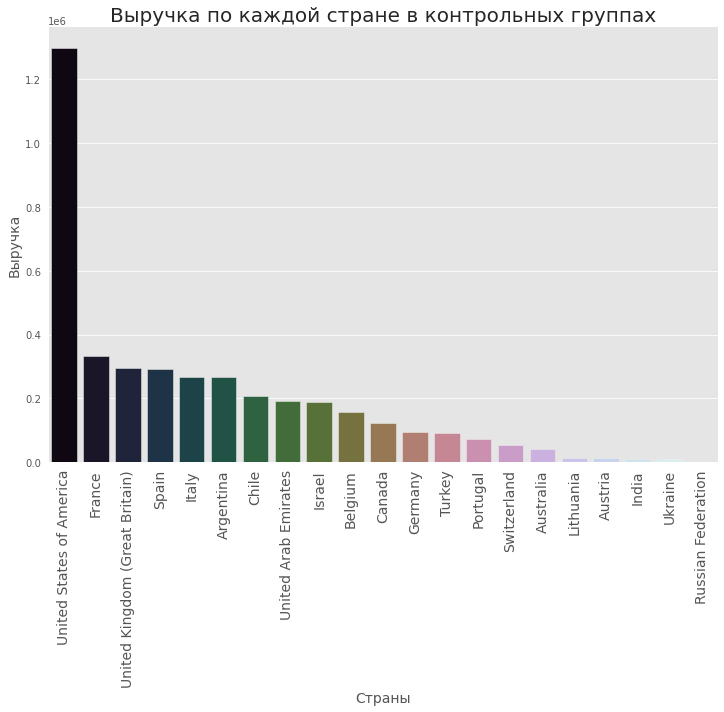

In [128]:
### Такую заготовку я заранее сделал и теперь использую всегда, когда мне нужен barplot:

sns.set_palette(sns.color_palette("Paired"))

#Устанавливаем размер и строим сам график
plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x="country", y="total_revenue", data=country_revenue_control, palette="cubehelix")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={'fontsize': 14})

#Устанавливаем заголовки
ax1.set_title("Выручка по каждой стране в контрольных группах", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.set_xlabel("Страны", fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax1.set_ylabel("Выручка", fontdict={'fontsize': 14, 'fontweight': 'medium'})

#Удаление лишнего при выводе и сам вывод
sns.despine()
plt.show()

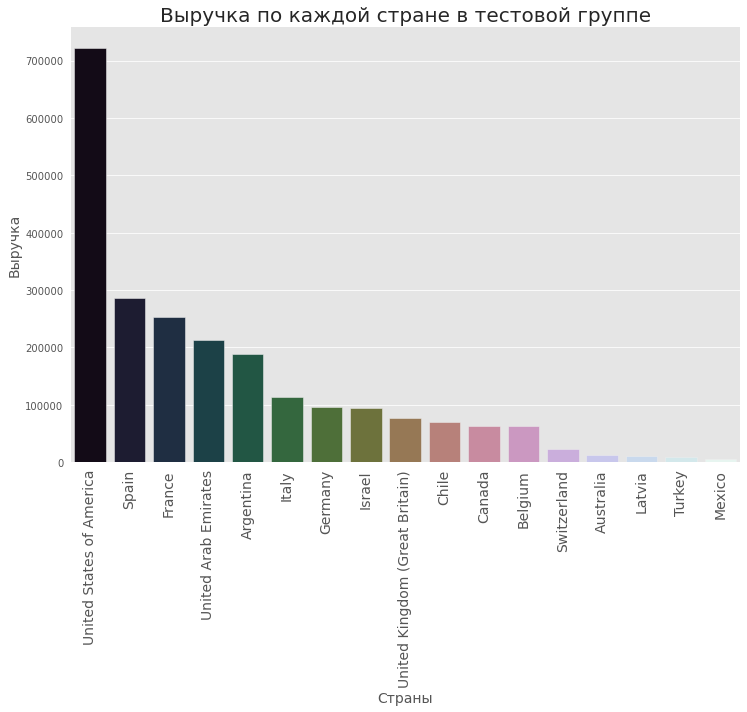

In [129]:
#Устанавливаем политру
needed_palette = sns.set_palette("icefire")

#Устанавливаем размер и строим сам график
plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x="country", y="total_revenue", data=country_revenue_test, palette="cubehelix")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontdict={'fontsize': 14})

#Устанавливаем заголовки
ax1.set_title("Выручка по каждой стране в тестовой группе", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.set_xlabel("Страны", fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax1.set_ylabel("Выручка", fontdict={'fontsize': 14, 'fontweight': 'medium'})

#Удаление лишнего при выводе и сам вывод
sns.despine()
plt.show()

##### Идеи для проверки гипотез по ab:
1. Смотреть на страны явно есть смысл;
2. Можно посмотреть на возраст. Далее  рассортировать наших покупателей по возрастным категориям и посмотреть где можно повнимательнее изучить данные;
3.  Также хочу почекать конверсию в покупку.

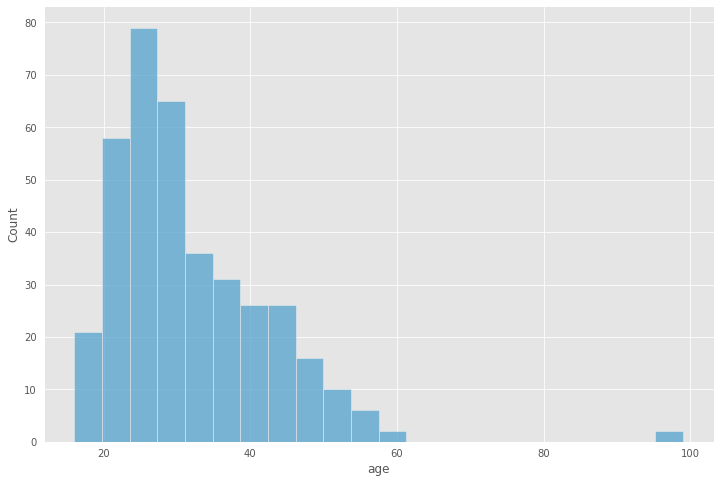

In [130]:
plt.figure(figsize=(12, 8))
sns.histplot(all_ctr.age)
sns.despine()

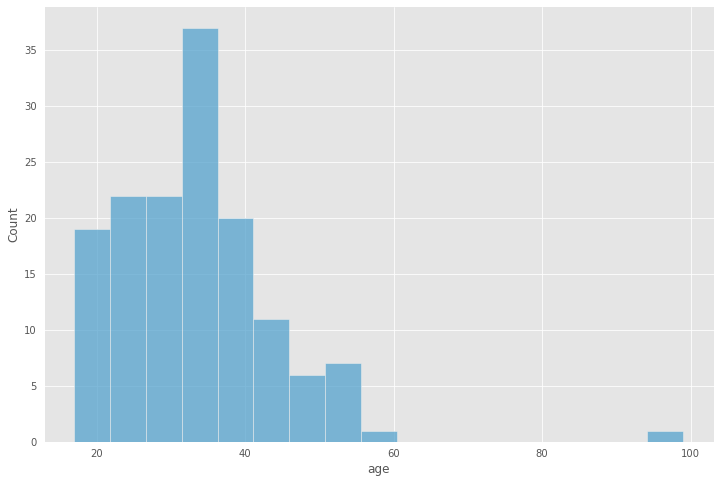

In [131]:
plt.figure(figsize=(12, 8))
sns.histplot(test1.age)
sns.despine()

In [132]:
test1.age.median()

33.0

Здесь я хочу написать функцию, которая бы сегментировала наших пользователей на 4 группы:

In [133]:
def age_group(df):
    #0 - первая группа, 1 - вторая, 2 - третья и 3 - четвертая, группы идут снизу вверх, то есть снизу 0 группа - это группа, где пользователи самые молодые
    age_lst = []
    for i in df.age:
        if 16 <= i <= 30:
            age_lst.append(0)
        elif 30 < i <= 40:
            age_lst.append(1)
        elif 40 < i <= 50:
            age_lst.append(2)
        elif i > 50:
            age_lst.append(3)

    df["age_group"] = age_lst
    return df

In [134]:
age_group(test1)

/tmp/ipykernel_4390/1829293622.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = age_lst


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,A/B_group,age_group
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,B,0
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,0.0,0.0,897,B,2
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,B,0
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580,B,0
105,892430988,28,181,0.0,United States of America,"1,2",1,25,31,22,1.0,1.0,12727,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,891226275,36,384,0.0,United States of America,"1,2",1,21,39,13,1.0,1.0,12727,B,1
4136,891718167,24,473,0.0,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17",1,16,30,19,1.0,1.0,8164,B,0
4173,891969984,39,166,0.0,Argentina,"1,1",1,26,43,12,1.0,1.0,5330,B,1
4176,892107222,32,400,0.0,United States of America,"1,2",1,29,35,20,1.0,1.0,9087,B,1


In [135]:
age_group(all_ctr)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,A/B_group,age_group
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,0.0,0.0,6396,A1,0
107,892380033,29,535,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,31,142,1.0,1.0,4732,A1,0
174,891292845,22,0,0.0,Italy,NaN,1,19,40,0,1.0,1.0,1898,A1,0
181,892336797,24,255,0.0,United States of America,"1,6,7,9,10,11,13,14",1,21,27,43,1.0,0.0,6292,A1,0
187,891264903,19,239,0.0,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761,A1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,892186737,30,250,0.0,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732,A2,0
4182,891333651,34,0,0.0,France,"2,3,4",1,31,37,0,0.0,0.0,1456,A2,1
4190,891452592,49,127,0.0,France,"1,2,3,4,5,6,7,8,9,10,11,12",1,39,48,837,1.0,1.0,15626,A2,2
4233,891213609,26,363,0.0,United States of America,NaN,1,23,29,11,1.0,1.0,6292,A2,0


Теперь я хочу посмотреть распределение стран и возрастов с использованием boxplot, при этом я думаю лучше бы оставить лишь 6 ключевых стран, чтобы график отображался нормально:

In [136]:
needed_countries = ["United States of America", "Spain", "France", "United Arab Emirates", "Argentina",
                    "United Kingdom (Great Britain)|"]

In [137]:
for_visualisation_test = test1.iloc[np.where(np.isin(test1["country"], needed_countries) == True)]
for_visualisation_control = all_ctr.iloc[np.where(np.isin(all_ctr["country"], needed_countries) == True)]

In [138]:
for_visualisation_control

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,A/B_group,age_group
107,892380033,29,535,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,31,142,1.0,1.0,4732,A1,0
181,892336797,24,255,0.0,United States of America,"1,6,7,9,10,11,13,14",1,21,27,43,1.0,0.0,6292,A1,0
187,891264903,19,239,0.0,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761,A1,0
208,891973917,25,125,0.0,France,"2,3,5,6,7,9,10,12,13,14,16,18,20,22",1,22,28,8,1.0,1.0,6344,A1,0
284,892421277,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333,A1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,892395564,32,439,0.0,United States of America,"1,2,3",0,29,35,878,0.0,0.0,2730,A2,1
4162,892385232,23,548,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,15,22,25,27,29,30",1,18,32,31,1.0,0.0,6292,A2,0
4182,891333651,34,0,0.0,France,"2,3,4",1,31,37,0,0.0,0.0,1456,A2,1
4190,891452592,49,127,0.0,France,"1,2,3,4,5,6,7,8,9,10,11,12",1,39,48,837,1.0,1.0,15626,A2,2


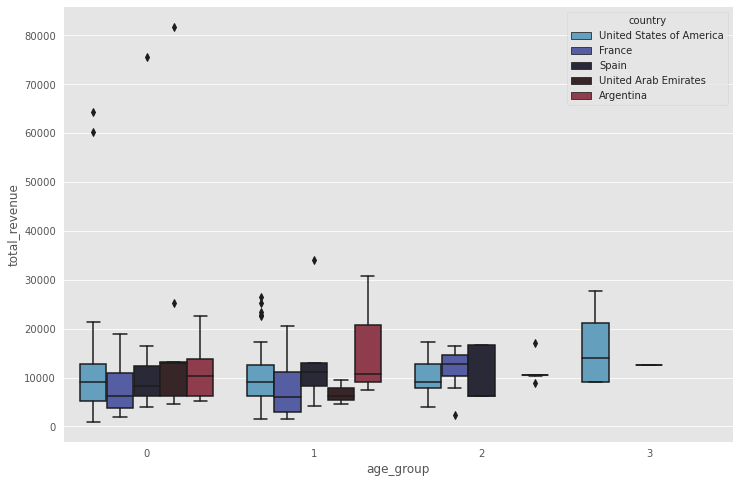

In [139]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="age_group", y="total_revenue", hue="country", data=for_visualisation_control)
sns.despine()

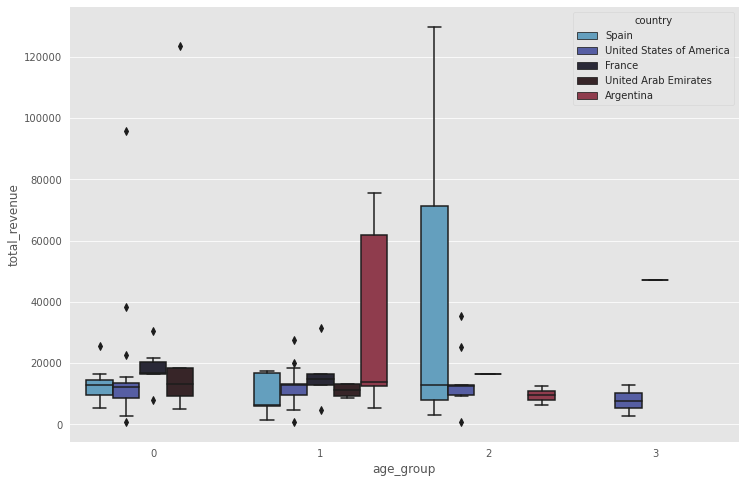

In [140]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="age_group", y="total_revenue", hue="country", data=for_visualisation_test)
sns.despine()

Выводы по визуализациям:
1. Во 2 и 3 группе в обоих группах пользователи находятся лишь в США;
2.  Сразу заметны различия по странам и в разных возрастных группах.

In [141]:
all_ctr = all_ctr[["uid", "age", "country", "total_revenue", "age_group", "A/B_group"]]
test1 = test1[["uid", "age", "country", "total_revenue", "age_group", "A/B_group"]]

In [142]:
test1.insert(6, "variant", "test")

In [143]:
all_ctr.insert(6, "variant", "control")

In [144]:
all_groups = pd.concat([test1, all_ctr])
all_groups.reset_index(inplace=True, drop=True)  #для красоты, так как мне привычно когда индексы идут по порядку
all_groups.head()

,uid,age,country,total_revenue,age_group,A/B_group,variant
0,891152790,29,Spain,12597,0,B,test
1,892333656,50,United States of America,897,2,B,test
2,891589239,21,Italy,37817,0,B,test
3,891343671,26,France,21580,0,B,test
4,892430988,28,United States of America,12727,0,B,test


In [145]:
all_groups.query("variant == 'test'").age_group.value_counts()

0    61
1    57
2    19
3     9
Name: age_group, dtype: int64

In [146]:
all_groups.query("variant == 'control'").age_group.value_counts()

0    217
1     88
2     56
3     17
Name: age_group, dtype: int64


Датасет к проверке первых гипотез готов, начнем проверку с такой гипотезы:
- H0 - разницы между средний total_revenue в тестовой и контрольной группы нету, и проверим мы эту гипотезу с помощью критерий Геймса-Хоувелла так как у между группами у нас различия в дисперсиях:

In [147]:
pg.pairwise_gameshowell(data=all_groups, dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A1,A2,10968.256545,10269.721925,698.534619,990.251581,0.705411,375.004890,0.760441,0.072424
1,A1,B,10968.256545,15759.027397,-4790.770853,1659.609047,-2.886686,211.715485,0.011914,-0.316627
2,A2,B,10269.721925,15759.027397,-5489.305472,1641.145809,-3.344801,204.105443,0.002806,-0.368561


p-value дает нам знак, что как и первой контрольной так и во второй группе отличается от тестовой и стоит отклонить H0

In [148]:
all_groups[all_groups["A/B_group"] == 'B'].total_revenue.mean()

15759.027397260274

In [149]:
all_groups[all_groups["A/B_group"] == 'A1'].total_revenue.mean()

10968.256544502618

In [150]:
all_groups[all_groups["A/B_group"] == 'A2'].total_revenue.mean()

10269.72192513369

Но лишь одной метрики в одном разрезе нам недостаточно, теперь я хочу попарно посмотреть по странам и по группам данный эксперимент:
- H0 - что разницы между средний total_revenue в тестовой и контрольной группой в возрастной группе 2 нету

In [151]:
pg.pairwise_gameshowell(data=all_groups[all_groups["age_group"] == 2], dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A1,A2,12142.000000,11049.566667,1092.433333,2201.516870,0.496218,30.983958,0.873637,0.131104
1,A1,B,12142.000000,18390.210526,-6248.210526,6795.396208,-0.919477,21.746884,0.634084,-0.272645
2,A2,B,11049.566667,18390.210526,-7340.643860,6509.273729,-1.127721,18.448277,0.509660,-0.325341


Здесь p-value показывает что нам не следует отклонять H0, теперь давайте проведем тоже самое для первой группы:

In [152]:
pg.pairwise_gameshowell(data=all_groups[all_groups["age_group"] == 1], dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A1,A2,10334.395349,10938.200000,-603.804651,1590.168487,-0.379711,84.956492,0.923678,-0.080267
1,A1,B,10334.395349,14513.473684,-4179.078335,1950.402060,-2.142675,90.664213,0.087003,-0.429477
2,A2,B,10938.200000,14513.473684,-3575.273684,2035.446287,-1.756506,96.543463,0.189838,-0.347639


Здесь p-value показывает что нам не следует отклонять H0. Очень интересно ведь это наши 2 ключевые группы, а обе они говорят что не нужно отклонять H0. Хочу попробовать удалить 3 и 4 возрастную группу и посмотреть что будет:


In [153]:
pg.pairwise_gameshowell(data=all_groups[all_groups["age_group"] < 3], dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A1,A2,11082.535912,10150.544444,931.991467,1027.366544,0.907165,356.262657,0.636127,0.095292
1,A1,B,11082.535912,15823.277372,-4740.741461,1742.891125,-2.720045,198.796611,0.019377,-0.307296
2,A2,B,10150.544444,15823.277372,-5672.732928,1715.287413,-3.307162,188.745643,0.003223,-0.374070


In [154]:
all_groups_usa = all_groups.query("country == 'United States of America'")

In [155]:
all_groups_usa[all_groups_usa["variant"] == "test"].age_group.value_counts()

0    22
1    19
2     9
3     2
Name: age_group, dtype: int64

In [156]:
all_groups_usa[all_groups_usa["variant"] == "control"].age_group.value_counts()

0    76
1    25
2    18
3     4
Name: age_group, dtype: int64

Вот здесь стоит посмотреть в разрезе на первую группу:

In [157]:
pg.pairwise_gameshowell(data=all_groups_usa[all_groups_usa["age_group"] == 1], dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A1,A2,12373.000000,9794.416667,2578.583333,3034.369238,0.849792,22.929437,0.676534,0.328974
1,A1,B,12373.000000,12519.000000,-146.000000,2510.074587,-0.058166,20.950905,0.998137,-0.020408
2,A2,B,9794.416667,12519.000000,-2724.583333,2531.885550,-1.076108,19.171251,0.539782,-0.386447


В данном случае мне кажется, что лучше довериться срезам, но при этом данная метрика(ARPPU) неоднозначная.
При этом я думаю можно посмотреть на конверсию, а также на ARPU, но сначала хочу посмотреть на данные о транзакциях:

In [158]:
display(transaction_test.head(),transaction_control1.head(),transaction_control2.head())

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


Также как и в 2 датасетах по информации о пользователях, я также хочу посмотреть на A/A тест для инфы по транзакциям:

  0%|          | 0/10000 [00:00<?, ?it/s]

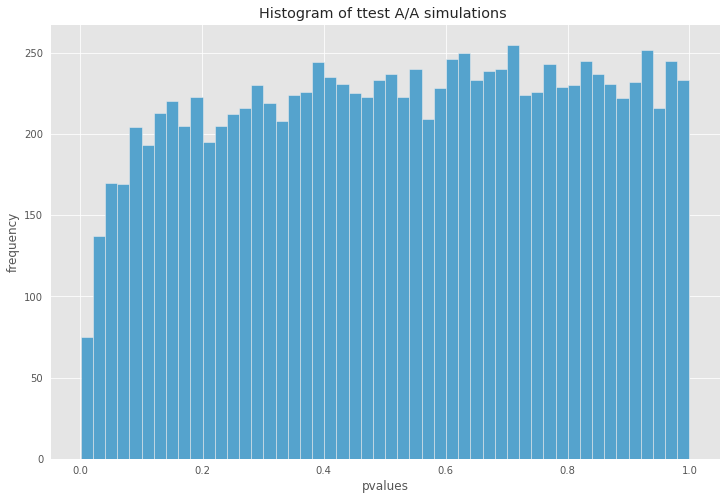

0.028

In [159]:
n = 100000
simulations = 10000
n_s = 100
new_res = []
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = transaction_control1.revenue.sample(n_s, replace=False).values
    s2 = transaction_control2.revenue.sample(n_s, replace=False).values
    res.append(ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.figure(figsize=(12, 8))
plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Так как значений у нас здесь поменьше, я поставил поменьше значение n_s, но при этом увеличил число итераций и как можно заметить A/A тест успешно был проведен.

In [160]:
transaction_test.insert(8,"A/B_group","B")

In [161]:
transaction_control1.insert(8,"A/B_group","A1")

In [162]:
transaction_control2.insert(8,"A/B_group","A2")

In [163]:
transaction_control = pd.concat([transaction_control1,transaction_control2])
transaction_control.insert(9,"variant","control")

In [164]:
transaction_test.insert(9,"variant","test")

In [165]:
all_transactions = pd.concat([transaction_test,transaction_control])

In [166]:
all_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,A/B_group,variant
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,B,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,B,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,B,test
3,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783.0,67.0,menu,other_type,B,test
4,892168170.0,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087.0,147.0,trial_vip_popup,trial_premium,B,test


### Продолжаем генить гипотезы:
____
Давайте проверим гипотезу:
 H0 - что ARPU в тестовой и контрольной группе одинаковое;

In [167]:
users_control1.insert(13,"A/B_group","A1")
users_control2.insert(13,"A/B_group","A2")

In [168]:
users_control1.insert(14,"variant","control")
users_control2.insert(14,"variant","control")

In [169]:
users_control = pd.concat([users_control1,users_control2])
users_control.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,A/B_group,variant
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0,A1,control
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0,A1,control
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0,A1,control
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0,A1,control
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0,A1,control


In [170]:
user_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0
1,892044516,27,0,0.0,Germany,NaN,1,24,30,0,0.0,0.0,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0
4,891406035,27,1000,0.0,France,NaN,1,24,30,1,1.0,0.0,0


In [171]:
user_test.insert(13,"A/B_group","B")
user_test.insert(14,"variant","test")

In [172]:
all_users = pd.concat([user_test,users_control])

In [173]:
all_users = all_users[["uid","age","country","total_revenue","A/B_group","variant"]]
all_users.head()

,uid,age,country,total_revenue,A/B_group,variant
0,892309896,27,United States of America,0,B,test
1,892044516,27,Germany,0,B,test
2,892185708,45,Israel,0,B,test
3,892130292,32,United States of America,0,B,test
4,891406035,27,France,0,B,test


In [174]:
pg.homoscedasticity(data=all_users, dv='total_revenue',group='A/B_group')

,W,pval,equal_var
levene,0.623986,0.535821,True


Дисперсия в группах равна, а теперь я хочу использовать попарный критерий Тьюки, а также использую bootstrap:
В первом опыте:
- H0 - среднее в total_revenue(ARPU) не отличается в зависимости от группы эксперимента.

In [175]:
pg.pairwise_tukey(data=all_users, dv="total_revenue", between="A/B_group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A1,A2,482.815626,450.384146,32.431479,75.450439,0.429838,0.903189,0.009268
1,A1,B,482.815626,534.080316,-51.264690,75.255854,-0.681205,0.774464,-0.014650
2,A2,B,450.384146,534.080316,-83.696169,75.584869,-1.107314,0.509539,-0.023918


- Тест подсказывает нам не отклонять H0, а именно, что различие между не зависимо какой контрольной группы и тестовой группой нету. -
- Теперь попробуем немного другую гипотезу, H0 - что в тестовой и контрольной группе различий нету.

In [177]:
test = all_users[all_users["variant"] == 'test']
control = all_users[all_users["variant"] == 'control']

  0%|          | 0/1000 [00:00<?, ?it/s]

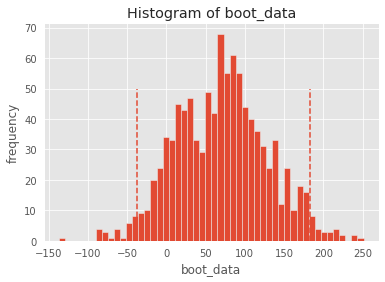

In [178]:
bootstraped_data = get_bootstrap(test.total_revenue,control.total_revenue)

In [179]:
bootstraped_data["p_value"]

0.22645111683858932

- И p-value и на самом графике видно, что интервал пересекает 0, поэтому нам стоит не отклонять H0;
- Остается лишь проверить конверсию, а проверять буду на конверсию в любую подписку с помощью z-test, где Нулевая гипотеза (H0) для теста состоит в том, что пропорции одинаковы. Альтернативная гипотеза (H1) заключается в том, что пропорции не совпадают и в нашем случае первая пропорция меньше.

In [180]:
stat, pval = proportions_ztest((test1.shape[0], ctr1.shape[0]),
                               (user_test.shape[0], users_control1.shape[0]),
                               alternative='smaller')

In [181]:
print('Конверсия в любую покупку test:control_1: '+'{0:0.5f}'.format(pval))

Конверсия в любую покупку test:control_1: 0.00748


In [182]:
stat, pval = proportions_ztest((test1.shape[0], ctr2.shape[0]),
                               (user_test.shape[0], users_control2.shape[0]),
                               alternative='smaller')
print('Конверсия в любую покупку test:control_2: '+'{0:0.3f}'.format(pval))

Конверсия в любую покупку test:control_2: 0.008


p-value подталкивает нас отклонить H0, при этом как мы можем видеть конверсия снизилась.

### Выводы:
____

В ходе исследований я считаю что данный эксперимент не стоит вводить так как:
1. ARPU - не показал никаких различий;
2. ARPPU - не показал никаких различий в разрезах по возрастной группе и по стране;
3. Снизилась конверсия в любую покупку.

На основе вышеперечисленных фактов, я думаю, что нам точно не стоит вводить фичу, которую мы тестировали в данном эксперименте.